<a href="https://colab.research.google.com/github/akashAD98/Rossmann-Sales-Prediction/blob/main/Rossmann_Sales_Prediction_AD_New_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rossmann Stores Sales Prediction

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")

import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings
warnings.filterwarnings("ignore")

In [4]:
#Read store dataset
store = pd.read_csv('/content/store.csv')
print(store.shape)
store.head(10)

(1115, 10)


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
5,6,a,a,310.0,12.0,2013.0,0,NaN,NaN,NaN
6,7,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN
7,8,a,a,7520.0,10.0,2014.0,0,NaN,NaN,NaN
8,9,a,c,2030.0,8.0,2000.0,0,NaN,NaN,NaN
9,10,a,a,3160.0,9.0,2009.0,0,NaN,NaN,NaN


In [5]:
#Read training dataset
train = pd.read_csv('/content/Rossmann Stores Data.csv',parse_dates = True, index_col = 'Date')
print(train.shape)
train.head(10)

(1017209, 8)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1
2015-07-31,6,5,5651,589,1,1,0,1
2015-07-31,7,5,15344,1414,1,1,0,1
2015-07-31,8,5,8492,833,1,1,0,1
2015-07-31,9,5,8565,687,1,1,0,1


### Missing Values 

In [6]:
print("train:\n\n", train.isnull().sum(),  
     "\n\nstore:\n\n", store.isnull().sum())

train:

 Store            0
DayOfWeek        0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64 

store:

 Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64


In [7]:
store = store.drop(['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear','Promo2SinceWeek',
                     'Promo2SinceYear', 'PromoInterval'], axis=1)
store.head(5)

,Store,StoreType,Assortment,CompetitionDistance,Promo2
0,1,c,a,1270.0,0
1,2,a,a,570.0,1
2,3,a,a,14130.0,1
3,4,c,c,620.0,0
4,5,a,a,29910.0,0


Text(0.5, 1.0, 'Distributin of Store Competition Distance')

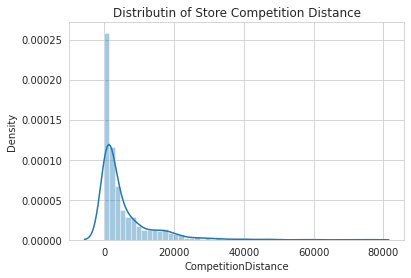

In [8]:
# Distribution of competition distance
sns.distplot(store.CompetitionDistance.dropna())
plt.title("Distributin of Store Competition Distance")

In [9]:
# replace missing values in CompetitionDistance with median
store.CompetitionDistance.fillna(store.CompetitionDistance.median(), inplace=True)

In [10]:
# extract year, month, day and week of year from "Date"
train['Year'] = train.index.year
train['Month'] = train.index.month
train['Day'] = train.index.day
train['WeekOfYear'] = train.index.weekofyear
train = train.reset_index()

In [11]:
train.head(5)

,Date,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear
0,2015-07-31,1,5,5263,555,1,1,0,1,2015,7,31,31
1,2015-07-31,2,5,6064,625,1,1,0,1,2015,7,31,31
2,2015-07-31,3,5,8314,821,1,1,0,1,2015,7,31,31
3,2015-07-31,4,5,13995,1498,1,1,0,1,2015,7,31,31
4,2015-07-31,5,5,4822,559,1,1,0,1,2015,7,31,31


### Joining tables

In [12]:
df = pd.merge(train, store, how='left', on='Store')
df.head()

,Date,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,StoreType,Assortment,CompetitionDistance,Promo2
0,2015-07-31,1,5,5263,555,1,1,0,1,2015,7,31,31,c,a,1270.0,0
1,2015-07-31,2,5,6064,625,1,1,0,1,2015,7,31,31,a,a,570.0,1
2,2015-07-31,3,5,8314,821,1,1,0,1,2015,7,31,31,a,a,14130.0,1
3,2015-07-31,4,5,13995,1498,1,1,0,1,2015,7,31,31,c,c,620.0,0
4,2015-07-31,5,5,4822,559,1,1,0,1,2015,7,31,31,a,a,29910.0,0


### Droping rows with no effect on prediction

In [13]:
df = df[df.Open != 0]

In [14]:
df.shape

(844392, 17)

In [15]:
df = df.drop('Open', axis=1)

In [16]:
df.shape

(844392, 16)

In [17]:
df[df.Sales == 0]['Store'].sum()

31460

In [18]:
df[df.Sales == 0]['Sales'].sum()/df.Sales.sum()

0.0

In [19]:
df = df[df.Sales != 0]

In [20]:
df.shape

(844338, 16)

### Feauture Engineering 

In [21]:
#Nominal attributes
set(df.StateHoliday), set(df.StoreType), set(df.Assortment)

({0, '0', 'a', 'b', 'c'}, {'a', 'b', 'c', 'd'}, {'a', 'b', 'c'})

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844338 entries, 0 to 1017190
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   Date                 844338 non-null  datetime64[ns]
 1   Store                844338 non-null  int64         
 2   DayOfWeek            844338 non-null  int64         
 3   Sales                844338 non-null  int64         
 4   Customers            844338 non-null  int64         
 5   Promo                844338 non-null  int64         
 6   StateHoliday         844338 non-null  object        
 7   SchoolHoliday        844338 non-null  int64         
 8   Year                 844338 non-null  int64         
 9   Month                844338 non-null  int64         
 10  Day                  844338 non-null  int64         
 11  WeekOfYear           844338 non-null  int64         
 12  StoreType            844338 non-null  object        
 13  Assortment   

In [23]:
df.loc[df.StateHoliday == 0,'StateHoliday'] = df.loc[df.StateHoliday == 0,'StateHoliday'].astype(str)

In [24]:
#Obtain copy of dataset for further use
df1 =  df.copy()
dfv = df.sample(n=5000, random_state=1)

In [25]:
# Adding New variable AvgSales 

sales = df1[['Year','Month','Store','Sales']].groupby(['Year','Month','Store']).mean()
sales.head(10)

Sales
Year Month Store             
2013 1     1      4939.653846
           2      4429.653846
           3      6371.269231
           4      9027.423077
           5      4209.307692
           6      5856.346154
           7      7232.000000
           8      4703.576923
           9      4885.230769
           10     5001.615385

In [26]:
sales = sales.rename(columns={'Sales':'AvgSales'})
sales = sales.reset_index()
sales.head(10)

,Year,Month,Store,AvgSales
0,2013,1,1,4939.653846
1,2013,1,2,4429.653846
2,2013,1,3,6371.269231
3,2013,1,4,9027.423077
4,2013,1,5,4209.307692
5,2013,1,6,5856.346154
6,2013,1,7,7232.000000
7,2013,1,8,4703.576923
8,2013,1,9,4885.230769
9,2013,1,10,5001.615385


In [27]:
df1['sales_key']=df1['Year'].map(str) + df1['Month'].map(str) + df1['Store'].map(str)
sales['sales_key']=sales['Year'].map(str) + sales['Month'].map(str) + sales['Store'].map(str)

In [28]:
sales = sales.drop(['Year','Month','Store'], axis=1)
# merge
df1 = pd.merge(df1, sales, how='left', on=('sales_key'))
df1.head(5)

,Date,Store,DayOfWeek,Sales,Customers,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,StoreType,Assortment,CompetitionDistance,Promo2,sales_key,AvgSales
0,2015-07-31,1,5,5263,555,1,0,1,2015,7,31,31,c,a,1270.0,0,201571,4491.333333
1,2015-07-31,2,5,6064,625,1,0,1,2015,7,31,31,a,a,570.0,1,201572,4954.259259
2,2015-07-31,3,5,8314,821,1,0,1,2015,7,31,31,a,a,14130.0,1,201573,6797.592593
3,2015-07-31,4,5,13995,1498,1,0,1,2015,7,31,31,c,c,620.0,0,201574,10256.851852
4,2015-07-31,5,5,4822,559,1,0,1,2015,7,31,31,a,a,29910.0,0,201575,4599.629630


In [29]:
# Adding New variable AvgCustomer

cust = df1[['Year','Month','Store','Customers']].groupby(['Year','Month', 'Store']).mean()
cust = cust.rename(columns={'Customers':'AvgCustomer'})
cust = cust.reset_index()

df1['cust_key']=df1['Year'].map(str) + df1['Month'].map(str) + df1['Store'].map(str)
cust['cust_key']=cust['Year'].map(str) + cust['Month'].map(str) + cust['Store'].map(str)

df1 = df1.drop('Customers', axis=1)# drop extra columns
cust = cust.drop(['Year', 'Month', 'Store'], axis=1)

df1 = pd.merge(df1, cust, how="left", on=('cust_key'))

In [30]:
df1.head(5)

,Date,Store,DayOfWeek,Sales,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,StoreType,Assortment,CompetitionDistance,Promo2,sales_key,AvgSales,cust_key,AvgCustomer
0,2015-07-31,1,5,5263,1,0,1,2015,7,31,31,c,a,1270.0,0,201571,4491.333333,201571,519.407407
1,2015-07-31,2,5,6064,1,0,1,2015,7,31,31,a,a,570.0,1,201572,4954.259259,201572,621.222222
2,2015-07-31,3,5,8314,1,0,1,2015,7,31,31,a,a,14130.0,1,201573,6797.592593,201573,682.888889
3,2015-07-31,4,5,13995,1,0,1,2015,7,31,31,c,c,620.0,0,201574,10256.851852,201574,1294.259259
4,2015-07-31,5,5,4822,1,0,1,2015,7,31,31,a,a,29910.0,0,201575,4599.629630,201575,521.703704


In [31]:
# stateholiday variable

df1['StateHoliday'] = df1.StateHoliday.map({'0':0, 'a':1 ,'b' : 1,'c': 1})
df1 = df1.drop(['cust_key','sales_key','Store','Date'], axis=1)

In [32]:
# we have converted stateholiday into 0 & 1 ,whether store is open =1 & closed =0

In [33]:
df1.head(5)

,DayOfWeek,Sales,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,StoreType,Assortment,CompetitionDistance,Promo2,AvgSales,AvgCustomer
0,5,5263,1,0,1,2015,7,31,31,c,a,1270.0,0,4491.333333,519.407407
1,5,6064,1,0,1,2015,7,31,31,a,a,570.0,1,4954.259259,621.222222
2,5,8314,1,0,1,2015,7,31,31,a,a,14130.0,1,6797.592593,682.888889
3,5,13995,1,0,1,2015,7,31,31,c,c,620.0,0,10256.851852,1294.259259
4,5,4822,1,0,1,2015,7,31,31,a,a,29910.0,0,4599.629630,521.703704



```

### EDA

In [34]:
corr = df1.corr()

Text(0.5, 1.0, 'Correlation Heatmap')

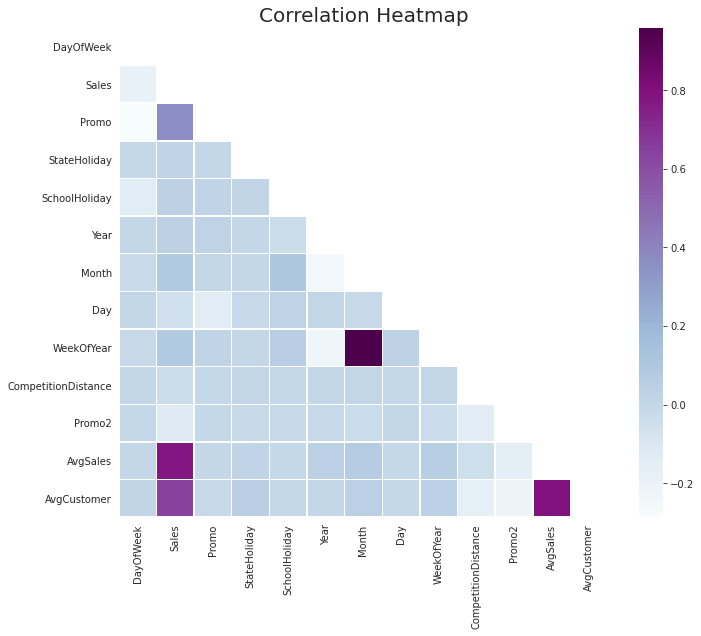

In [35]:
mask = np.zeros_like(corr, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize = (11, 9))
sns.heatmap(corr, mask = mask,
            square = True, linewidths = .5, ax = ax, cmap = "BuPu")
plt.title("Correlation Heatmap", fontsize=20)

Common observation drawn from result is also that some stores always perform better than others. This 
might be because of factors unique to that particular store and not represented in given data. 
After AvgSales second best feature was Promo. Sales are highly correlated to promotion from store. Sales 
are observed to be increased around 30% in the period of promotions. So regression models learned this 
feature so whenever there is promotion for store it is predicted high sales for that store. This can be 
important thing to note for store managers as a future strategy to improve business.

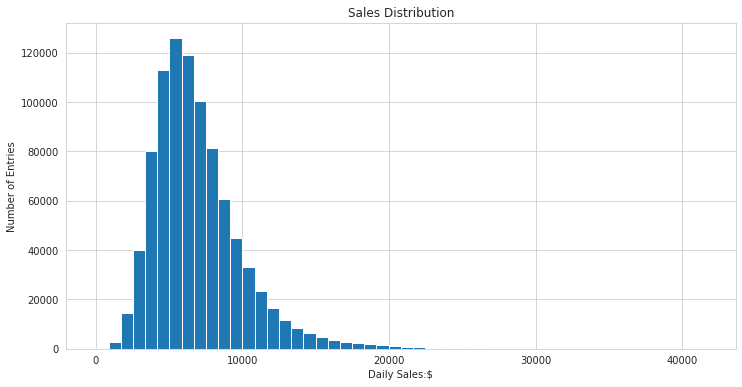

In [36]:
plt.figure(figsize=(12, 6))
plt.xlabel('Daily Sales:$')
plt.ylabel('Number of Entries')
plt.title('Sales Distribution')
plt.hist(x=df1.Sales,bins=50);

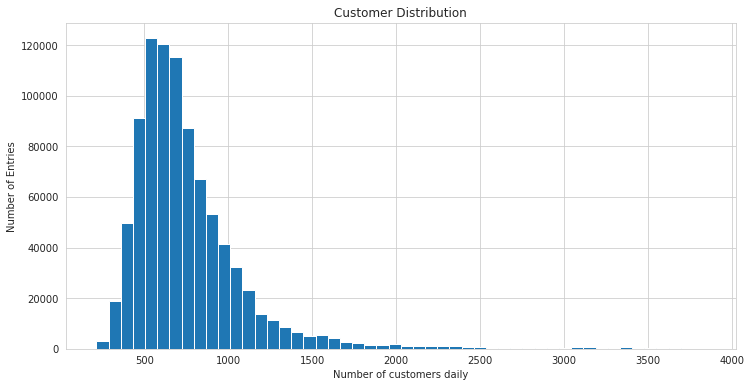

In [37]:
plt.figure(figsize=(12, 6))
plt.xlabel('Number of customers daily')
plt.ylabel('Number of Entries')
plt.title('Customer Distribution')
plt.hist(x=df1.AvgCustomer,bins=50);

In [38]:
promo0 = df1.query('Promo==0')
promo0 = promo0.rename(columns={'Sales':'No_Promotion_Sales'})
promo1 = df1.query('Promo==1')
promo1 = promo1.rename(columns={'Sales':'Promotion_Sales'})
x1 = promo0.No_Promotion_Sales
x2 = promo1.Promotion_Sales

Text(0, 0.5, 'Sales')

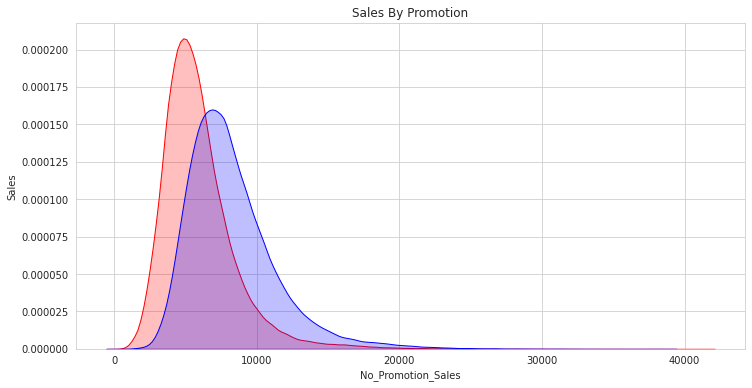

In [39]:

plt.figure(figsize=(12,6))
ax = sns.kdeplot(x1, shade=True, color="r")
ax = sns.kdeplot(x2, shade=True, color="b")
plt.title("Sales By Promotion")
plt.ylabel('Sales')

In [40]:
#EDA

# sales vs date

1
(781, 16)


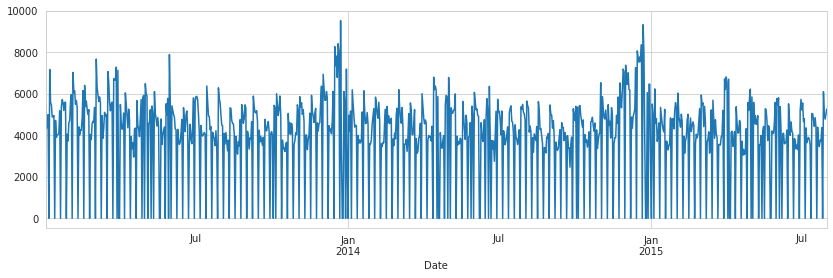

In [41]:

df['Date'] = pd.to_datetime(df['Date'], format = '%Y-%m-%d')

store_id = df.Store.unique()[0]
print(store_id)
store_rows = df[df['Store'] == store_id]
print(store_rows.shape)
store_rows.resample('1D', on='Date')['Sales'].sum().plot.line(figsize=(14,4))

In [44]:
df1.columns

Index(['DayOfWeek', 'Sales', 'Promo', 'StateHoliday', 'SchoolHoliday', 'Year',
       'Month', 'Day', 'WeekOfYear', 'StoreType', 'Assortment',
       'CompetitionDistance', 'Promo2', 'AvgSales', 'AvgCustomer'],
      dtype='object')

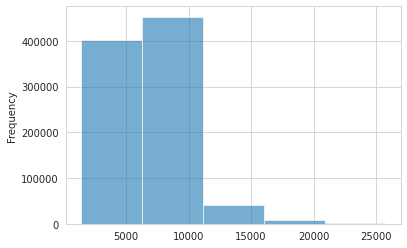

In [45]:
df1['AvgSales'].plot.hist(bins=5,alpha=0.6)

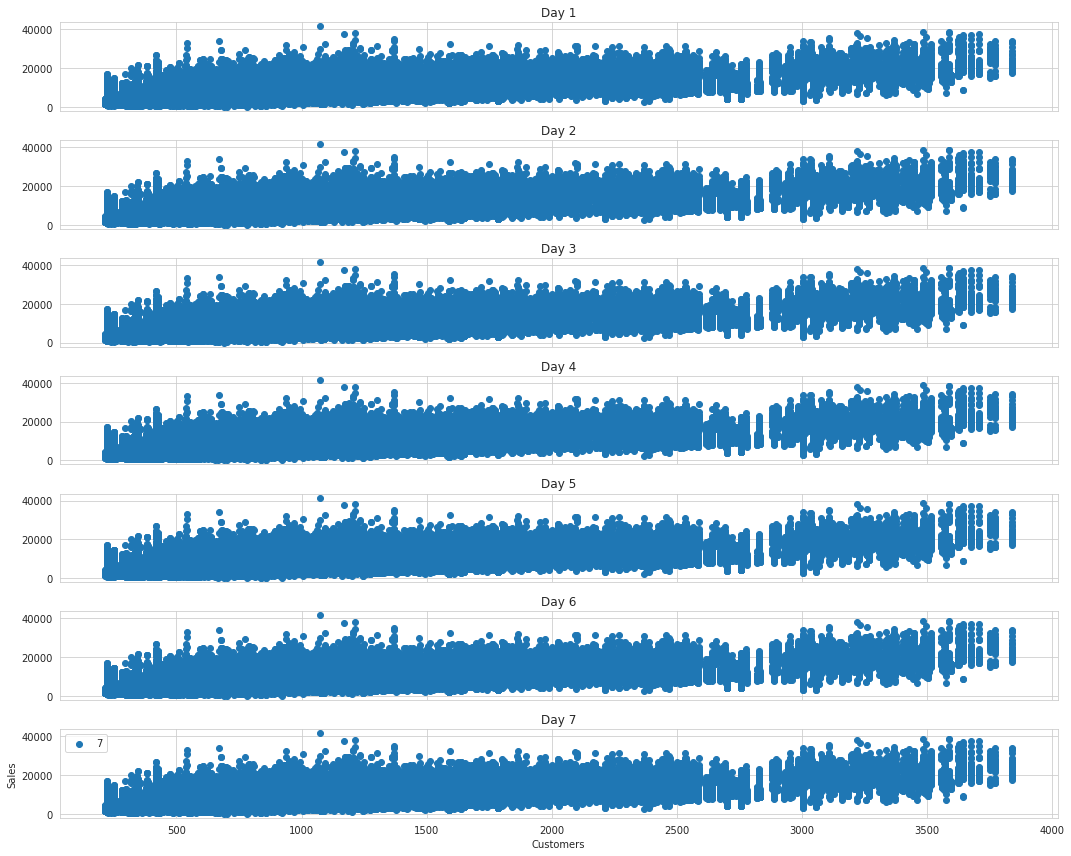

In [46]:
plt.rcParams['figure.figsize'] = (15.0,12.0)

f,ax = plt.subplots(7, sharex=True, sharey=True)
for i in range(1,8):
    data = df1[df1['DayOfWeek'] == i ]
    ax[i - 1].set_title("Day {0}".format(i))
    ax[i - 1].scatter(df1['AvgCustomer'],df1['Sales'],label=i)
    
plt.legend()
plt.xlabel('Customers')
plt.ylabel('Sales')
plt.tight_layout()
plt.show()

In [61]:
# method to plot a graph for count per hour
def plot_hours(data, message = ''):
    dd = data.copy()
    dd['hour'] = data.datetime.dt.hour # extratcing the hour
    
    hours = {}
    for hour in range(24):
        hours[hour] = dd[ dd.hour == hour ]['count'].values

    plt.figure(figsize=(15,10))
    plt.ylabel("Count rent")
    plt.xlabel("Hours")
    plt.title("count vs hours\n" + message)
    plt.boxplot( [hours[hour] for hour in range(24)] )
    
    axis = plt.gca()
    axis.set_ylim([1, 1100])
 

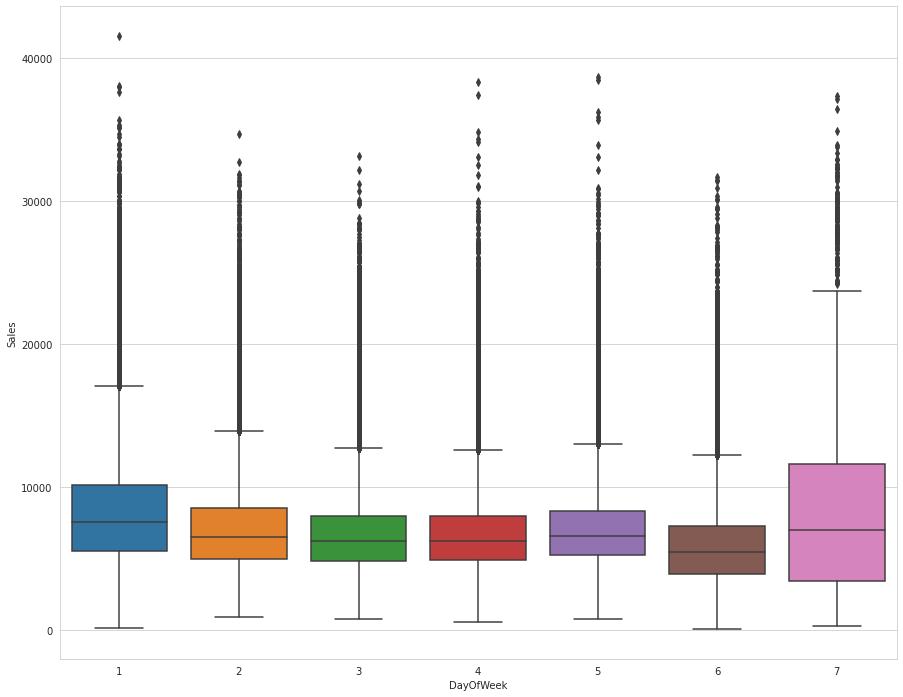

In [63]:
import seaborn as sns
ax = sns.boxplot(x="DayOfWeek", y="Sales", data=df1)

From the plot, we can tell that Tue through Fri’s sales distributions are very close. Mon, Sat and Sun’s sales distributions are unique. In database, DayofWeek is represented as numeric number From plot, we know that there is no linear relationship from 1­7 number to sales data. We treat DayofWeek as four factors, Mon


1-Monday,2-Tuesday,3-wen,4-thur,5-frid 6-sat,7-sunday


in sunday sales is high ,even if you dont applied promo


In [49]:
# Customer Vs Sales of Different Days of the Week

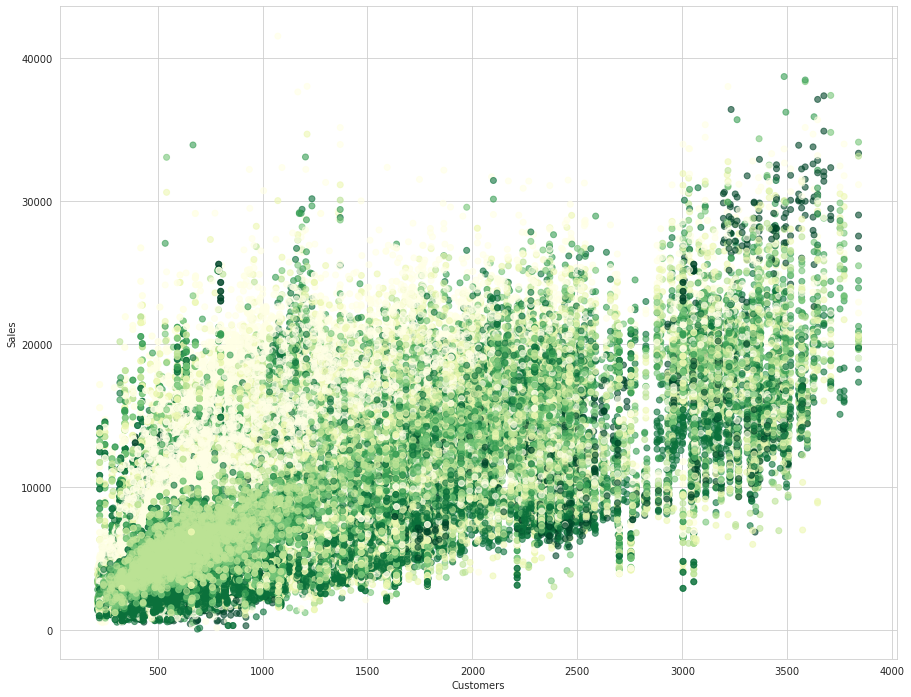

In [64]:
plt.scatter(df1['AvgCustomer'], df1['Sales'], c=df1['DayOfWeek'],label=i,alpha=0.6,cmap=plt.cm.get_cmap('YlGn'))

plt.xlabel('Customers')
plt.ylabel('Sales')
plt.show()

In [51]:
#School Holiday Vs Sales

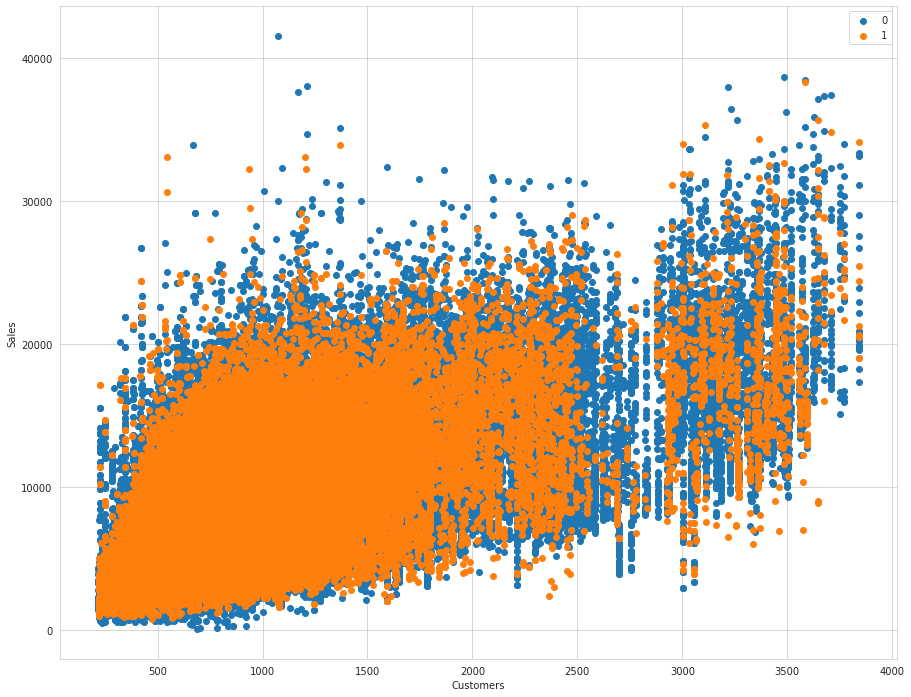

In [65]:
for i in [0,1]:
    data = df1[df1['SchoolHoliday'] == i]
    if (len(data) == 0):
        continue
    plt.scatter(data['AvgCustomer'], data['Sales'], label = i)
 

plt.legend()
plt.xlabel('Customers')
plt.ylabel('Sales')
plt.show()

In [53]:
###### School Holidays doesnt have much impact on sales at the store.

In [54]:
# Effect of Promo Code on Sales

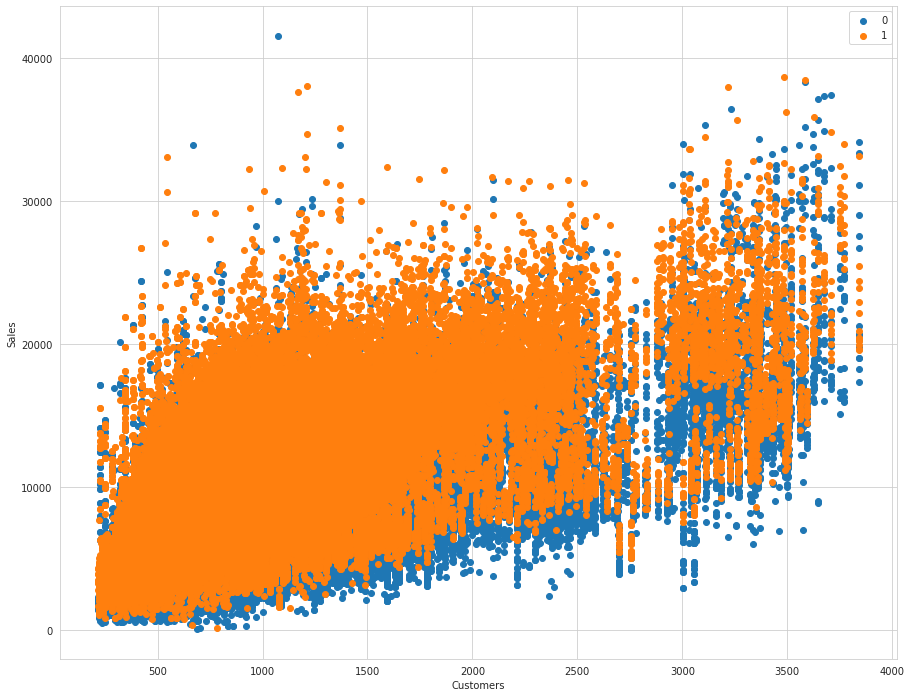

In [66]:
for i in [0,1]:
    data = df1[df1['Promo'] == i]
    if (len(data) == 0):
        continue
    plt.scatter(data['AvgCustomer'], data['Sales'], label = i)
    
plt.legend()
plt.xlabel('Customers')
plt.ylabel('Sales')
plt.show()

In [56]:
## We know by intution that promo code should have an effect on sales.We can confirm from the above plot that promo code did have an affect on the sales.

In [57]:
## Average Customer Vs Average Sales

In [58]:
Here we have plotted a scatter plot with store type as hue.We can clearly see that as the average customers increases at the store the sales increases.This is quite Natural.

We can see that store type b has more Average Customers and sales.This may be because the store type b is in urban areas or it sells products which are more in demand.

SyntaxError: ignored

In [ ]:
## Competition Distance Vs Average Sales

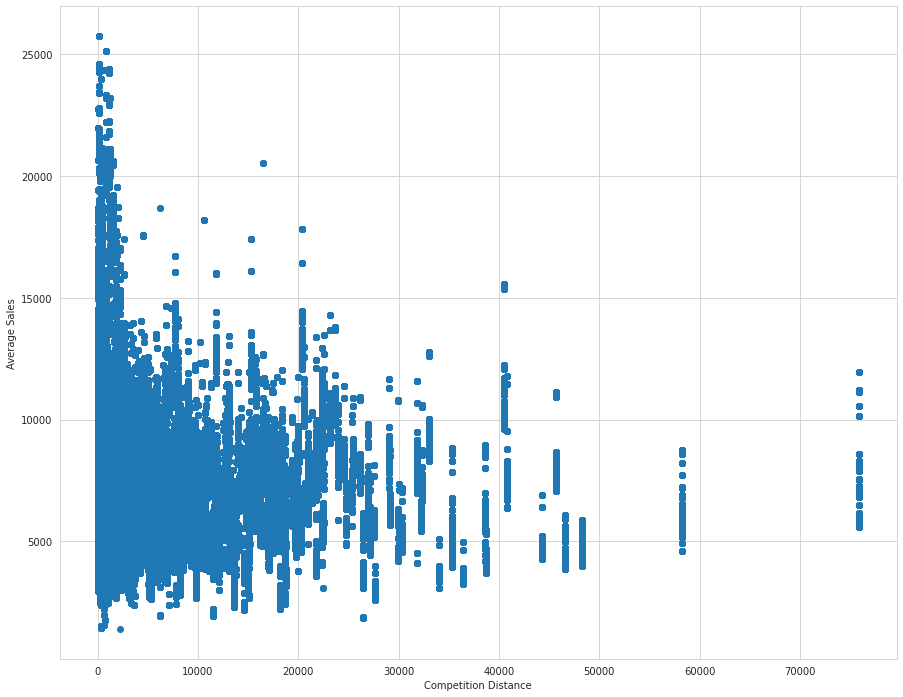

In [ ]:
df1["CompetitionDistance"].fillna(-1)

plt.scatter(df1['CompetitionDistance'],df1['AvgSales'])

plt.xlabel('Competition Distance')
plt.ylabel('Average Sales')
plt.show()

Competition Distance is the distance of other store with the Rossmann Store.We can see that when the competition disance is low then the sales is more.This is counter intutive that if there are competitors aroud you then your sales is also more.

This is because store are more in urban areas. And in urban areas the stores of competitors are also present.Sales happen more in Urban areas that is why even if competitors are nearby the sales are more.

In [ ]:
Sales Over Weeks

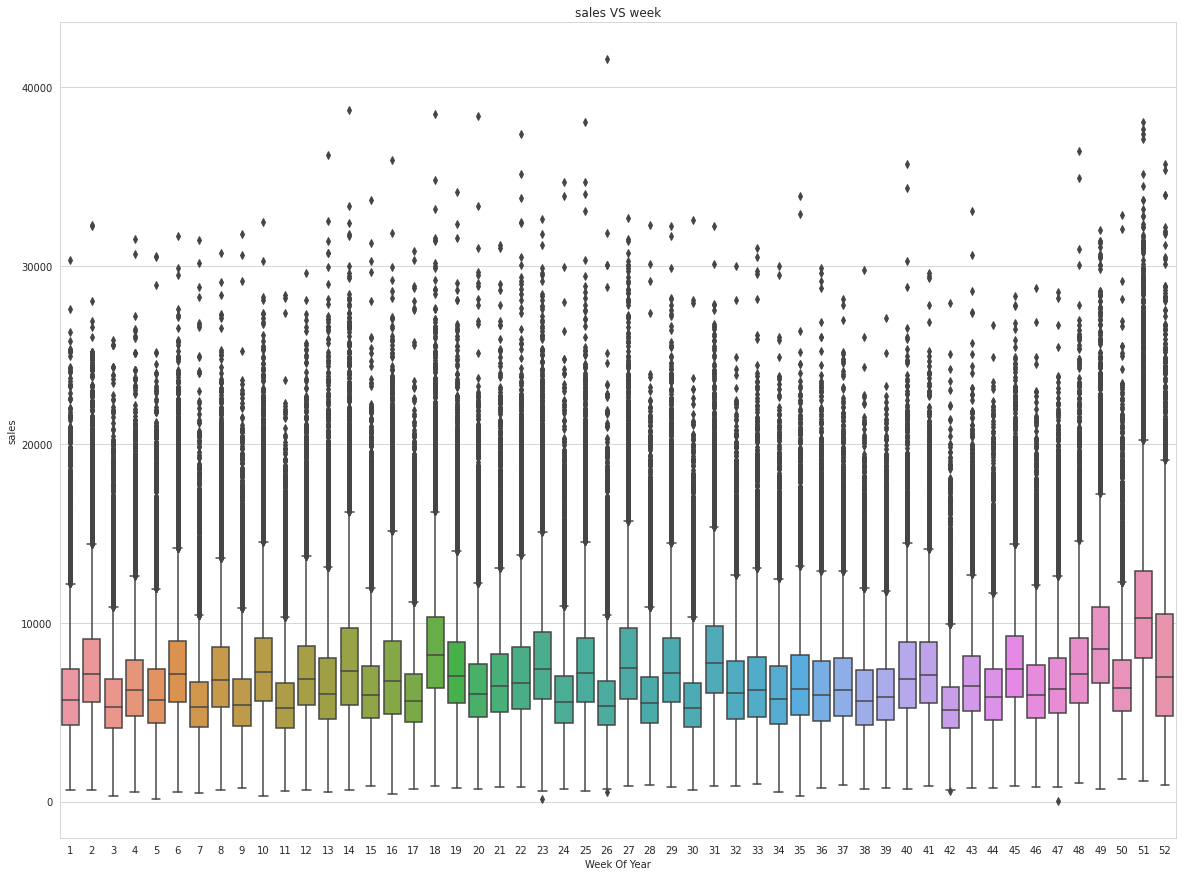

In [ ]:
plt.figure(figsize=(20,15))
sns.boxplot(x='WeekOfYear',y='Sales',data=df1)
plt.title('sales VS week')
plt.xlabel('Week Of Year')
plt.ylabel('sales')
plt.show()

In [ ]:
plt.figure(figsize=(20,15))
sns.boxplot(x='DayOfWeek',y='Sales',data=df)
plt.title('sales VS week')
plt.xlabel('Day Of Week')
plt.ylabel('total sales')
plt.show()

In [ ]:
Sales by Store Type

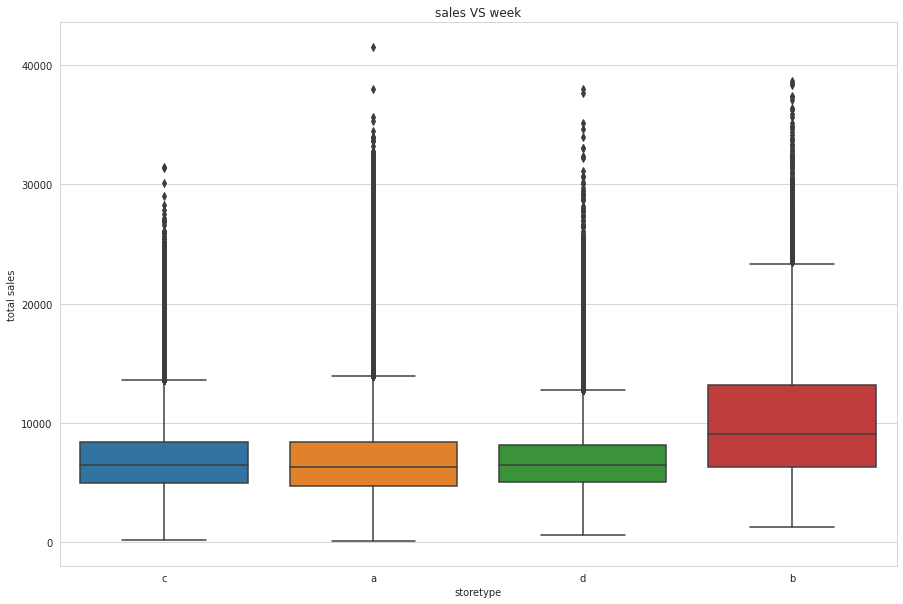

In [ ]:
plt.figure(figsize=(15,10))
sns.boxplot(x='StoreType',y='Sales',data=df1)
plt.title('sales VS week')
plt.xlabel('storetype')
plt.ylabel('total sales')
plt.show()

In [ ]:
#storetype b has more sales compaird to a,b,c

In [69]:
# Sales vs. Number Of Customers


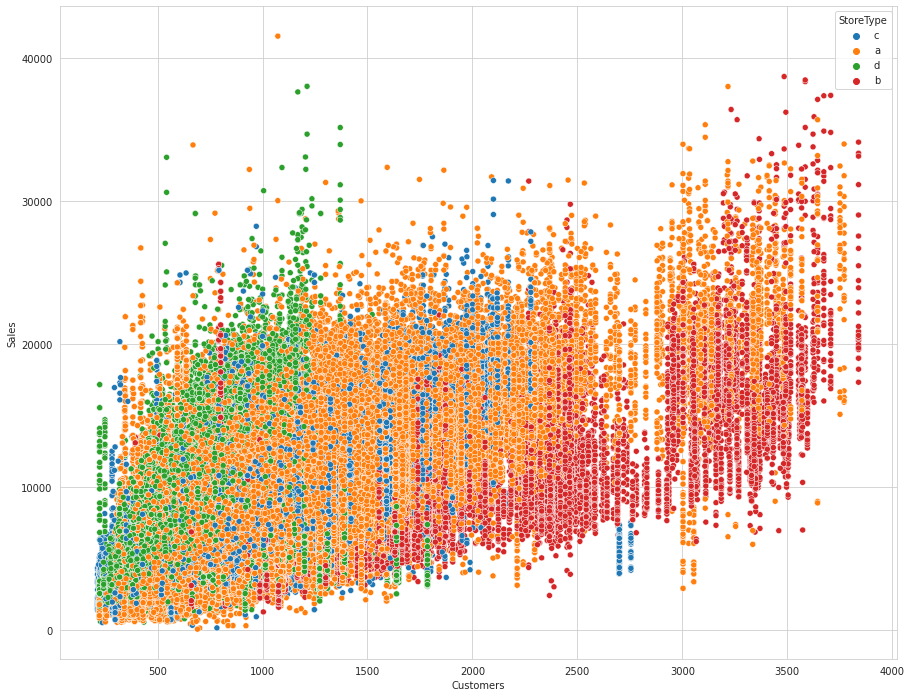

In [68]:
import seaborn as sns

sns.scatterplot(data=df1, x="AvgCustomer", y="Sales",hue='StoreType')
plt.xlabel('Customers')
plt.ylabel('Sales')
plt.show()

## Prediction Models

In [70]:
#df1.shape
dfd = df1.sample(n=50000, random_state=1)

In [71]:
#Divide training dataset in x and y
X = dfd.drop('Sales', axis=1)
y = dfd.Sales

In [72]:
y.head(10)

79585      8581
342406     7983
546552    12259
606893     3650
666534     8518
551508     5392
530010     4484
100265     5819
621142     5333
786882     5227
Name: Sales, dtype: int64

In [73]:
xd = X.copy()
xd = pd.get_dummies(xd)

In [76]:

xd_train,xd_test,yd_train,yd_test = train_test_split(xd,y,test_size=0.2, random_state=1)

In [77]:
xl = X.copy()

# Lable encoding

label = LabelEncoder()
xl.StateHoliday = label.fit_transform(xl.StateHoliday)
xl.Assortment = label.fit_transform(xl.Assortment)
xl.StoreType = label.fit_transform(xl.StoreType)

In [78]:
#label encoder of DT models
xl_train,xl_test,yl_train,yl_test = train_test_split(xl,y,test_size=0.2, random_state=1)

## 1. Linear Regression

In [82]:
#Build linear regression model
lin_model = LinearRegression()

#Train model on training dataset
lin_model.fit(xd_train, yd_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [83]:
#Error functions

def mape(x, y): 
    return np.mean(np.abs((x - y) / x)) * 100  

def rmspe(y_true, y_pred):
    '''
    Compute Root Mean Square Percentage Error between two arrays.
    '''
    loss = np.sqrt(np.mean(np.square(((y_true - y_pred) / y_pred)), axis=0))

    return loss

In [84]:
#Predict using model

yd_predicted = lin_model.predict(xd_train)

#Calculate RMSE and MAPE

print("The model performance for training dataset:\n")
print("RMSPE :",rmspe(yd_train, yd_predicted))
print("MAPE :",mape(yd_train, yd_predicted))

The model performance for training dataset:

RMSPE : 0.23877125072212077
MAPE : 17.047674300272362


In [85]:
#Predict target on test data using model

yd_test_predicted = lin_model.predict(xd_test)

#Calculate RMSE and MAPE

print("The model performance for training dataset:\n")
print("RMSPE :",rmspe(yd_test, yd_test_predicted))
print("MAPE :",mape(yd_test, yd_test_predicted))

The model performance for training dataset:

RMSPE : 0.23111099241896388
MAPE : 17.057881528022776


## 2. Decision Tree

In [86]:
#Build decision tree model
tree_model = DecisionTreeRegressor(min_samples_leaf=20)

#Train model on training dataset
tree_model.fit(xl_train, yl_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=20, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [87]:
#Predict using model

yl_pred = tree_model.predict(xl_train)

#Calculate RMSE and MAPE

print("The model performance for training dataset:\n")
print("RMSPE :",rmspe(yl_train, yl_pred))
print("MAPE :",mape(yl_train, yl_pred))



The model performance for training dataset:

RMSPE : 0.16438725714933122
MAPE : 12.280456460848619


In [88]:

#Predict target on test data using model

yl_pred_test = tree_model.predict(xl_test)

#Calculate RMSE and MAPE

print("The model performance for training dataset:\n")
print("RMSPE :",rmspe(yl_test, yl_pred_test))
print("MAPE :",mape(yl_test, yl_pred_test))


The model performance for training dataset:

RMSPE : 0.19486735609648367
MAPE : 14.200549289686634


## 3. Random Forest 

In [89]:
xl_train,xl_test,yl_train,yl_test = train_test_split(xl,y,test_size=0.2, random_state=1)

In [90]:
#Build random forest model
rdf_model = RandomForestRegressor(n_estimators=30)

#Train model on training dataset
rdf_model.fit(xl_train, yl_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [91]:
#Predict using model
#train
yl_pred = rdf_model.predict(xl_train)


#Calculate RMSE and MAPE

print("The model performance for training dataset:\n")
print("RMSPE :",rmspe(yl_train, yl_pred))
print("MAPE :",mape(yl_train, yl_pred))

The model performance for training dataset:

RMSPE : 0.06586055807866685
MAPE : 4.7258116339515155


In [92]:
#Predict target on test data using model

yl_pred_test = rdf_model.predict(xl_test)

#Calculate RMSE and MAPE

print("The model performance for training dataset:\n")
print("RMSPE :",rmspe(yl_test, yl_pred_test))
print("MAPE :",mape(yl_test, yl_pred_test))

The model performance for training dataset:

RMSPE : 0.16510442405346207
MAPE : 12.335986214431868


In [118]:
rdf_model.score(xl_test, yl_test)

0.8471884872641485

In [101]:


regressor=[['Liner Regression :',LinearRegression()],
       ['Decision Tree reg :',DecisionTreeRegressor()],
       ['Random Forest regre :',RandomForestRegressor()]]
rmse_score=[]
mape_score=[]
for name,model in regressor:
    model=model
    model.fit(xl_train,yl_train)
    predictions = model.predict(xl_test)
    rmse_score.append(rmspe(yl_test,predictions))
    mape_score.append(mape(yl_test,predictions))
    #print('RMSE Score')
    print('RMSE score',name,rmspe(yl_test,predictions))
    print('MAPE score',name,mape(yl_test,predictions))
    

RMSE score Liner Regression : 0.23146055647096067
MAPE score Liner Regression : 17.050718937415287
RMSE score Decision Tree reg : 0.26633446484397894
MAPE score Decision Tree reg : 16.755649705627746
RMSE score Random Forest regre : 0.16286816076365956
MAPE score Random Forest regre : 12.107465275856926


In [102]:
y_hats_test  = pd.DataFrame(yl_pred_test)

In [103]:
yl_test

210495    12912
442986     5388
126948     7613
90677      6153
282283     3455
          ...  
377481     5125
346255     4861
304079    11242
305832     4783
388569     4976
Name: Sales, Length: 10000, dtype: int64

In [104]:
actual=[]
for i in yl_test:
    actual.append(i)
    

In [105]:
actual_pred=actual

In [106]:
actual_sale_val=pd.DataFrame(actual_pred)

In [107]:
actual_sale_val

,0
0,12912
1,5388
2,7613
3,6153
4,3455
...,...
9995,5125
9996,4861
9997,11242
9998,4783


In [108]:
predicted_sale_val=pd.DataFrame(y_hats_test)

In [109]:
predicted_sale_val

,0
0,11724.666667
1,4925.466667
2,6575.633333
3,6002.733333
4,3289.566667
...,...
9995,5628.933333
9996,4580.266667
9997,9411.400000
9998,5664.666667


In [110]:
frames = [actual_sale_val,predicted_sale_val]

In [111]:
result1 = pd.concat([actual_sale_val,predicted_sale_val], axis=1)

In [112]:
result1.columns

Int64Index([0, 0], dtype='int64')

In [113]:
result1.set_axis(['Actual_sales', 'predicted_sales'], axis=1, inplace=True)

In [114]:
result1

,Actual_sales,predicted_sales
0,12912,11724.666667
1,5388,4925.466667
2,7613,6575.633333
3,6153,6002.733333
4,3455,3289.566667
...,...,...
9995,5125,5628.933333
9996,4861,4580.266667
9997,11242,9411.400000
9998,4783,5664.666667


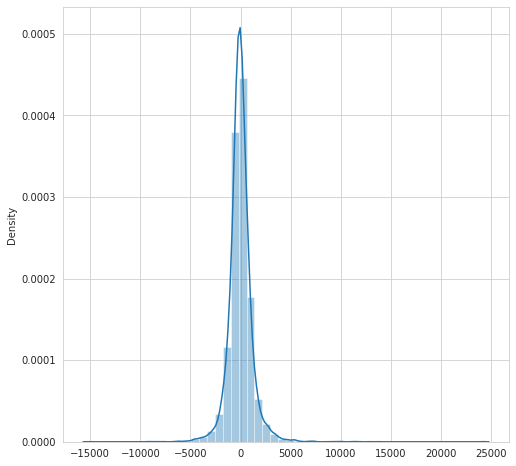

In [ ]:
plt.figure(figsize = (8,8))
sns.distplot(result1.Actual_sales-result1.predicted_sales)
plt.show()

In [119]:
# result is Gausian distributed so our model is good

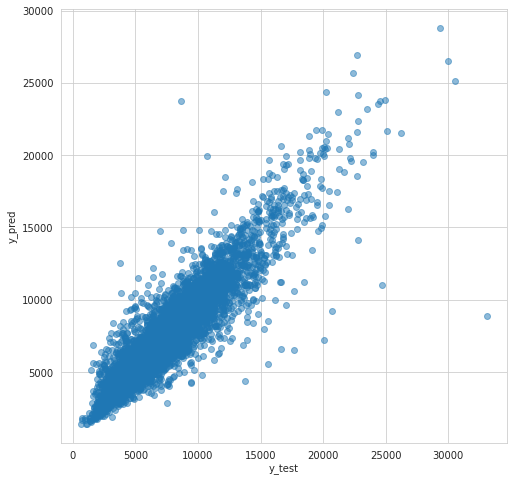

In [ ]:
plt.figure(figsize = (8,8))
plt.scatter(yl_test,predicted_sale_val, alpha = 0.5)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

(521.984497563192, 40294.598974088694, 1232.501739497454, 41005.11621602296)

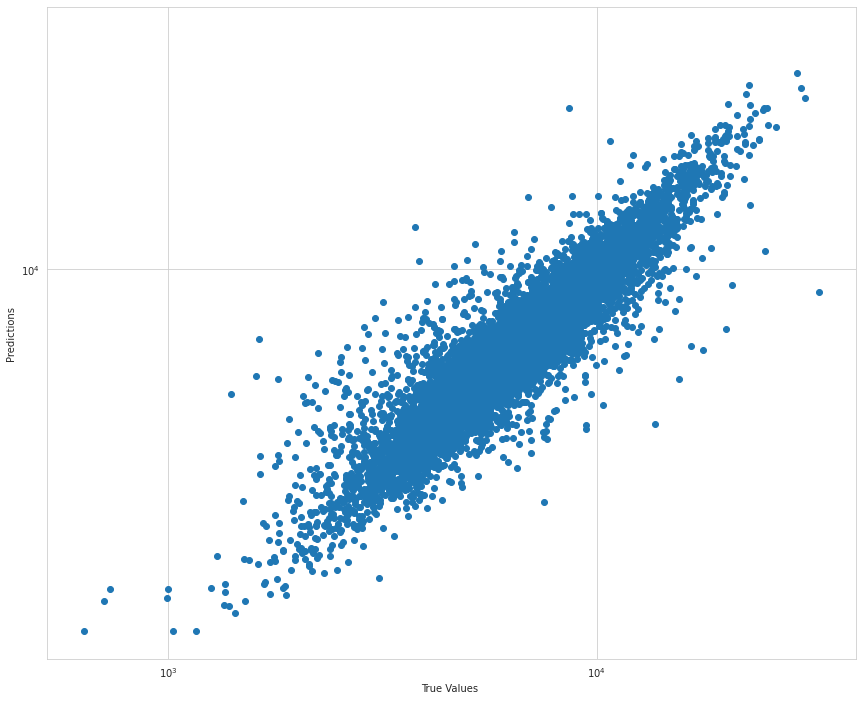

In [ ]:
g=plt.scatter(result1.Actual_sales,result1.predicted_sales)
g.axes.set_yscale('log')
g.axes.set_xscale('log')
g.axes.set_xlabel('True Values ')
g.axes.set_ylabel('Predictions ')
g.axes.axis('equal')
g.axes.axis('square')


In [ ]:
## testing pkl file

In [120]:
import pickle

In [122]:
import pickle
# open a file, where you ant to store the data
file = open('rf_model_sales.pkl', 'wb')

# dump information to that file
pickle.dump(rdf_model, file)

In [124]:
model = open('rf_model_sales.pkl','rb')
forest = pickle.load(model)

In [ ]:
#hyperparam RF

In [ ]:
regressor=RandomForestRegressor()

In [ ]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
print(n_estimators)

[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200]


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
 #Randomized Search CV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]
# max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 100]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10]


In [ ]:
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

print(random_grid)

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200], 'max_features': ['auto', 'sqrt'], 'max_depth': [5, 10, 15, 20, 25, 30], 'min_samples_split': [2, 5, 10, 15, 100], 'min_samples_leaf': [1, 2, 5, 10]}


In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()

In [ ]:
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid,scoring='neg_mean_squared_error', n_iter = 10, cv = 5, verbose=2, random_state=42, n_jobs = 1)

In [ ]:
rf_random.fit(xl_train,yl_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=  30.6s
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   30.6s remaining:    0.0s


[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=  30.9s
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 
[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=  31.0s
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 
[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=  31.2s
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 
[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=  31.1s
[CV] n_estimators=1100, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=15 
[CV]  n_estimators=1100, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=15, total=  51.1s
[CV] n_estimators=1100, min_samples_split=10, mi

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 50.1min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [ ]:
rf_random.best_params_

{'max_depth': 25,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 1000}

In [ ]:
rf_random.best_score_

-1326661.735196582

In [ ]:
predictions=rf_random.predict(xl_test)

In [ ]:
sns.distplot(y_test-predictions)

In [ ]:
predictions=rf_random.predict(X_test)

In [ ]:
#after hyperparam

In [125]:
#Build random forest model
rdf_model1 = RandomForestRegressor(max_depth= 25,
 max_features='sqrt',
 min_samples_leaf=1,
 min_samples_split= 2,
 n_estimators= 2000  )
#Train model on training dataset
rdf_model1.fit(xl_train, yl_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=25, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=2000, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [126]:
#Predict using model
#train
yl_pred = rdf_model1.predict(xl_train)

#Calculate RMSE and MAPE

print("The model performance for training dataset:\n")
print("RMSPE :",rmspe(yl_train, yl_pred))
print("MAPE :",mape(yl_train, yl_pred))

The model performance for training dataset:

RMSPE : 0.06167217344453233
MAPE : 4.536897987485066


In [127]:
#Predict target on test data using model

yl_pred_test = rdf_model1.predict(xl_test)

#Calculate RMSE and MAPE

print("The model performance for training dataset:\n")
print("RMSPE :",rmspe(yl_test, yl_pred_test))
print("MAPE :",mape(yl_test, yl_pred_test))

The model performance for training dataset:

RMSPE : 0.157196555239474
MAPE : 11.932388466143152


In [ ]:
# RF performing good ,so we select simple rf without hyperparam tunning.

In [128]:
#XGBOOST model

##GB model

In [129]:
from sklearn.ensemble import GradientBoostingRegressor

In [138]:
gb = GradientBoostingRegressor(n_estimators= 1500,max_depth=4,min_samples_leaf=2)
gb.fit(xl_train, yl_train)


GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=4,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=2, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=1500,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [139]:
#Predict using model
#train
yl_pred = gb.predict(xl_train)

#Calculate RMSE and MAPE

print("The model performance for training dataset:\n")
print("RMSPE :",rmspe(yl_train, yl_pred))
print("MAPE :",mape(yl_train, yl_pred))

The model performance for training dataset:

RMSPE : 0.12152289334809427
MAPE : 9.353355007784009


In [140]:
#Predict target on test data using model

yl_pred_test = gb.predict(xl_test)

#Calculate RMSE and MAPE

print("The model performance for training dataset:\n")
print("RMSPE :",rmspe(yl_test, yl_pred_test))
print("MAPE :",mape(yl_test, yl_pred_test))

The model performance for training dataset:

RMSPE : 0.15573223660532853
MAPE : 11.153622694184982
